# Players Playing Style

The goal of this notebook is try **capture the players playing style**, using event data.

In order to do that, ***Non Negative Matrix Factorization*** will be used to extract the generic pitch locations that describes each event occurrence.

This approach was based on the paper: *Characterizing Soccer Players’ Playing Style from Match Event Streams*

For helping in the pitch plot, LaurieOnTracking code was used from: https://github.com/Friends-of-Tracking-Data-FoTD/LaurieOnTracking

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from mplsoccer import Pitch, Radar, PyPizza, add_image, FontManager

from PIL import Image

from sklearn.decomposition import NMF

import json
import LaurieOnTracking_SourceCode.Metrica_Viz as mviz

# Load data

In [3]:
#data from https://figshare.com/collections/Soccer_match_event_dataset/4415000/2
with open('data/events_England.json') as f:
    data = json.load(f)
    

df_events = pd.DataFrame(data)

# event data - Premier League
with open('data/matches_England.json') as f:
    matches_df = json.load(f)
    
matches_df = pd.DataFrame(matches_df)


# get Man City ID
with open('data/teams.json') as f:
    teams_data = json.load(f)
teams_df = pd.DataFrame(teams_data)

man_city_id = teams_df[teams_df['officialName'] == 'Manchester City FC'].iloc[0]['wyId']


# get Players
with open('data/players.json') as f:
    players_data = json.load(f)

players_df = pd.DataFrame(players_data)


def get_player_name(p_id):
    return players_df[players_df.wyId == p_id].iloc[0].shortName

city_players = players_df[players_df['currentTeamId'] == man_city_id]
city_players_ids = city_players['wyId'].values

field_dim =(106, 68)

In [4]:
event_ids_mapping = {i: rows['eventName'].unique()[0] for i, rows in df_events.groupby(['eventId'])}
subevent_ids_mapping = {i: rows['subEventName'].unique()[0] for i, rows in df_events.groupby(['subEventId'])}

event_ids_mapping, subevent_ids_mapping

({1: 'Duel',
  2: 'Foul',
  3: 'Free Kick',
  4: 'Goalkeeper leaving line',
  5: 'Interruption',
  6: 'Offside',
  7: 'Others on the ball',
  8: 'Pass',
  9: 'Save attempt',
  10: 'Shot'},
 {10: 'Air duel',
  11: 'Ground attacking duel',
  12: 'Ground defending duel',
  13: 'Ground loose ball duel',
  20: 'Foul',
  21: 'Hand foul',
  22: 'Late card foul',
  23: 'Out of game foul',
  24: 'Protest',
  25: 'Simulation',
  26: 'Time lost foul',
  27: 'Violent Foul',
  30: 'Corner',
  31: 'Free Kick',
  32: 'Free kick cross',
  33: 'Free kick shot',
  34: 'Goal kick',
  35: 'Penalty',
  36: 'Throw in',
  40: 'Goalkeeper leaving line',
  50: 'Ball out of the field',
  51: 'Whistle',
  70: 'Acceleration',
  71: 'Clearance',
  72: 'Touch',
  80: 'Cross',
  81: 'Hand pass',
  82: 'Head pass',
  83: 'High pass',
  84: 'Launch',
  85: 'Simple pass',
  86: 'Smart pass',
  90: 'Reflexes',
  91: 'Save attempt',
  100: 'Shot',
  '': ''})

# Extract specific events

In [5]:
#EVENTS
DUEL_ID = 1
FOUL_ID = 2
FREE_KICK_ID = 3
OTHERS_ID = 7
PASSES_ID = 8
SAVE_ATTEMPT_ID = 9
SHOTS_ID = 10

#SUBEVENTS
CORNERS = 30
ACCELERATION = 70
CLEARANCE = 71
PASS_CROSS = 80
PASS_SIMPLE = 85

#TAGS
TAG_GOAL_ID = 101
TAG_OPPORTUNITY = 201
TAG_ASSIST_ID = 301
TAG_KEY_PASS = 302
TAG_YELLOW_CARD = 1702
TAG_RED_CARD = 1701


def check_tag(df, tag_id):
    """
    check presence of tag
    """
    for t in df['tags']:
        if t['id'] == tag_id:
            return True
    return False


def extract_events_by_team(df, event_id, subevent_id, tag_id, players_ids):
    """
    extract events of a specific team and with a given event_id (, sub_event_id and tag)
    """
    df = df[(df['playerId'].isin(players_ids)) & (df['eventId'] == event_id)]
    
    if subevent_id != -1:
        df = df[(df['subEventId'] == subevent_id)]
        
    if tag_id != -1:
        df = df[df.apply(check_tag, tag_id=tag_id, axis=1)]
        
    return df.reset_index(drop=True)
  
    
def extract_positions(pos, real_dim=(106, 68)):
    """
    extract positions from dictionary field
    """
    if len(pos) == 1:
        pos.append(pos[0])
    
    x_i = float(pos[0]['x'] * real_dim[0] * 0.01)
    y_i = float(pos[0]['y'] * real_dim[1] * 0.01)
    x_f = float(pos[1]['x'] * real_dim[0] * 0.01)
    y_f = float(pos[1]['y'] * real_dim[1] * 0.01)
    
    return pd.Series([x_i, y_i, x_f, y_f])



In [694]:

    
def get_player_grid(df, p_id, blur=False, feat_w='x_i', feat_h='y_i'):
    """
    compute player grid, with the number of a given event (e.g. shots) events in each grid block
    aplication of a gaussian blur, if required
    """
    if p_id != -1:
        df = df[df.playerId == p_id]
    
    n_grid = (40, 25)
    w_bins = np.linspace(0, field_dim[0], n_grid[0])
    h_bins = np.linspace(0, field_dim[1], n_grid[1])
    
    grid = np.zeros((n_grid[1]-1, n_grid[0]-1))
    
    df['w_bin'] = pd.cut(df[feat_w], w_bins, labels=[i for i in range(n_grid[0]-1)])
    df['h_bin'] = pd.cut(df[feat_h], h_bins, labels=[i for i in range(n_grid[1]-1)])

    #heatmap, xedges, yedges = np.histogram2d(df['x_i'], df['y_i'], bins=[40, 25])
    
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            grid[i, j] = len(df[(df['h_bin'] == i) & (df['w_bin'] == j)])

    if blur:
        grid = gaussian_filter(grid, sigma=2)
        
    return grid


def plot_grid(grid):
    """
    plot the player grid, computed above. 
    It will give an overview of the locations in the field where a given event occurs most frequently
    """
    extent = [-field_dim[0]/2, field_dim[0]/2, -field_dim[1]/2, field_dim[1]/2]

    fig, ax = mviz.plot_pitch(field_dimen = field_dim)

    #Greens_r, inferno, hot
    img = ax.imshow(grid, interpolation='nearest', extent=extent, cmap='hot')
    fig.colorbar(img)

    plt.show()
    
    return ax



In [6]:
# players id
for p in city_players_ids:
    print(p, get_player_name(p))

265673 Bernardo Silva
70083 Danilo
70086 N. Otamendi
38021 K. De Bruyne
71654 Ederson
105339 Fernandinho
8277 K. Walker
8307 V. Kompany
8317 David Silva
8325 S. Ag\u00fcero
8464 F. Delph
9380 J. Stones
11066 R. Sterling
340386 Gabriel Jesus
14808 \u0130. G\u00fcndo\u011fan
26136 B. Mendy
241564 O. Zinchenko
245364 L. San\u00e9
3662 C. Bravo
70085 E. Mangala
26150 R. Mahrez
134502 A. Laporte
404397 Brahim Diaz
447205 P. Foden


# Playing style - Non Negative Matrix Factorization

Playing style will by applying Non Negative Matrix Factorization

In [33]:
def compute_nmf(X, n_comp=4):
    """
    Apply Non Negative Matrix Factorization algorithm
    """
    model = NMF(n_components=n_comp, init='random', random_state=10)
    W = model.fit_transform(X)
    H = model.components_
    H = H.reshape([n_comp, 24, 39])
    
    for c in H:
        plot_grid(c)

    return W, H

# Shot Analysis

The shots heatmaps of each player can generally be described by 4 generic pitch areas: from the **right side**, from the **left side**, from the **center (close to the goal)** and in the **center, out of the box**.

Each player will have a set of 4 weights assigned, representing the shot frequency in each of these 4 zones

/Users/danielazevedo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/danielazevedo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


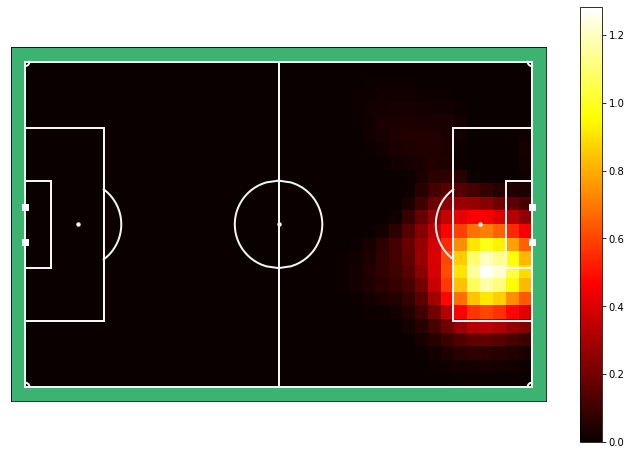

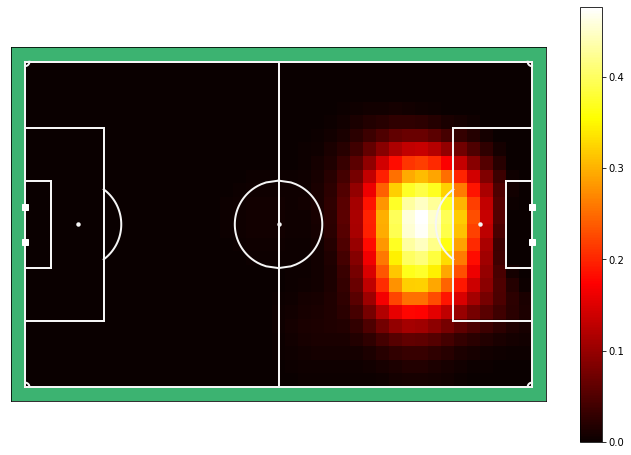

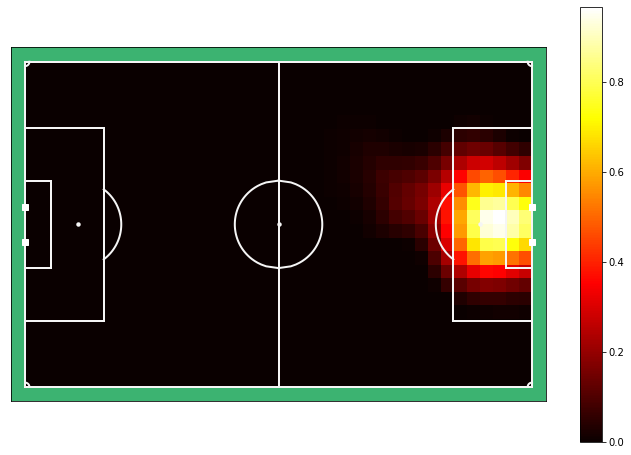

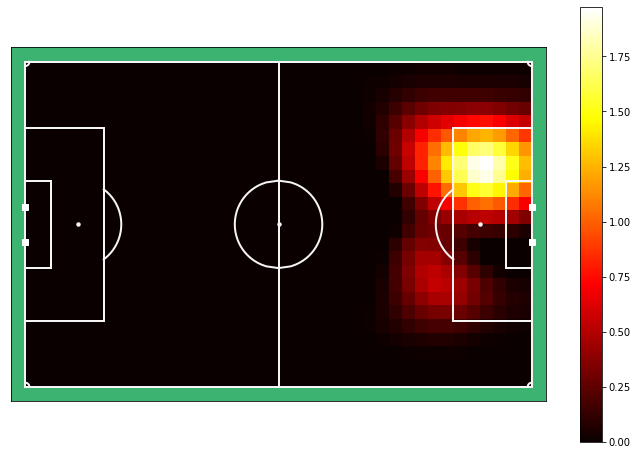

In [667]:
df = extract_events_by_team(df_events.copy(), SHOTS_ID, -1, -1, city_players_ids)
df[['x_i', 'y_i', 'x_f', 'y_f']] = df['positions'].apply(extract_positions)

grid_matrix = []

for p in city_players_ids:
    p_grid = get_player_grid(df.copy(), p, True)
    grid_matrix.append(p_grid.reshape(-1))
    
X = np.array(grid_matrix)

W, H = compute_nmf(X, 4)

# Shots heatmap + xG model

The xGmodel implementation can be seen in https://github.com/danielazevedo/Football-Analytics/tree/master/expected_goals

In [697]:
# load data from xG model trained before

with open('X.pickle', 'rb') as handle:
    new_X = pickle.load(handle)

with open('model.pickle', 'rb') as handle:
    clf = pickle.load(handle)

/Users/danielazevedo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/danielazevedo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


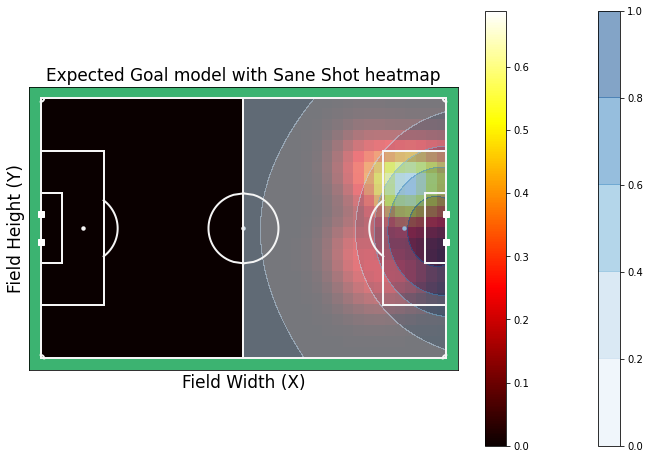

In [808]:
def xG_plot_grid(grid, p):

    extent = [-field_dim[0]/2, field_dim[0]/2, -field_dim[1]/2, field_dim[1]/2]

    fig, ax = mviz.plot_pitch(field_dimen = field_dim)
    
    if p ==245364:
        p_name = 'Sane'
    else:
        p_name = get_player_name(p)
    
    #xG model
    X0, X1 = new_X[:, 0], new_X[:, 1]
    xx, yy = make_meshgrid(X0, X1)


    out, Z, new_coords = plot_contours(ax, clf, xx, yy, cmap="Blues", alpha=0.5, levels=4)

    #ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlabel('Field Width (X)', fontsize=17)
    ax.set_ylabel('Field Height (Y)', fontsize=17)
    ax.set_title(f'Expected Goal model with {p_name} Shot heatmap', fontsize=17)


    fig.colorbar(out)
    
    

    #Greens_r, inferno, hot
    img = ax.imshow(grid, interpolation='nearest', extent=extent, cmap='hot')
    fig.colorbar(img)

    #plt.show()
    
    return ax, fig

# example
p = 245364
p_grid = get_player_grid(df.copy(), p, True)
ax, fig = xG_plot_grid(p_grid, p)


def make_meshgrid(x, y, h=1):
    x_min, x_max = x.min(), x.max() - 45
    y_min, y_max = y.min() + 16, y.max() - 15
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    
    coords = np.c_[xx.ravel(), yy.ravel()]
    new_coords = []

    for v in coords:
        d = compute_distance(v[0], v[1]-50)
        a = compute_angle(v[0], v[1]-50)
        new_coords.append([v[0], v[1], a, d])
    
    new_coords = np.array(new_coords)

    Z = clf.predict_proba(new_coords)
    Z = Z[:, 0].reshape(xx.shape)
    out = ax.contourf(xx, yy-50, np.fliplr(1-Z), **params)
    return out, Z, new_coords


plt.show()

# Defending Duel Analysis

Analysis of the 3 pitch areas that better define the most common duel zones

/Users/danielazevedo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/Users/danielazevedo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


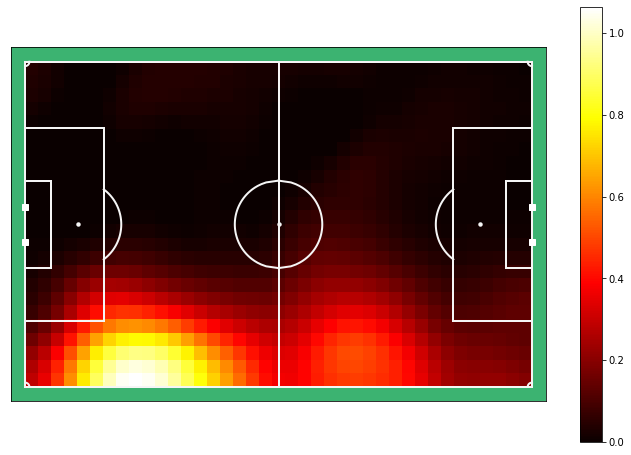

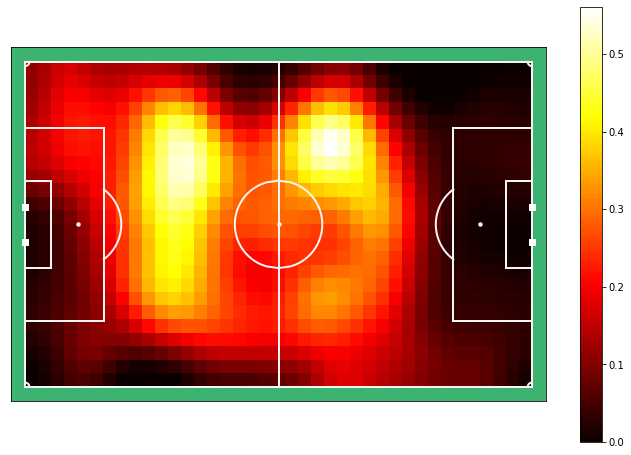

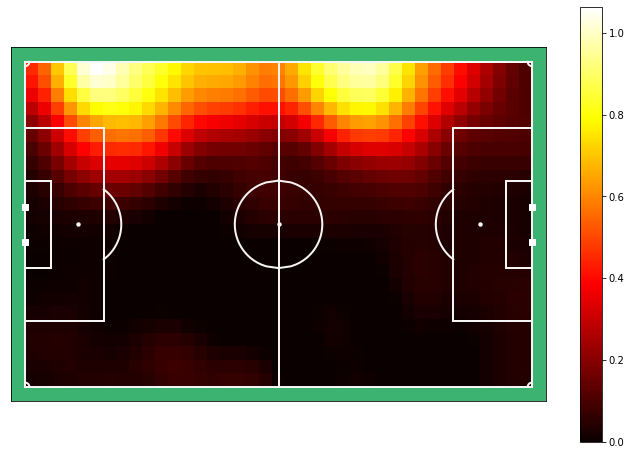

In [160]:
df = extract_events_by_team(df_events.copy(), DUEL_ID, 12, -1, city_players_ids)
df[['x_i', 'y_i', 'x_f', 'y_f']] = df['positions'].apply(extract_positions)


grid_matrix = []

for p in city_players_ids:
    p_grid = get_player_grid(df.copy(), p, True)
    grid_matrix.append(p_grid.reshape(-1))
    #plot_grid(p_grid)
    
X = np.array(grid_matrix)

W, H = compute_nmf(X, 3)

# Plot players playing style

Each **player playing style** will be defined by a **vector composed by the weights of the NMF applied to a set of events**

In [ ]:
total_features = []

# set of events considered, each with an individual configuration
ev = [SHOTS_ID, FOUL_ID, OTHERS_ID, PASSES_ID, DUEL_ID]
sub_ev = [-1, -1, ACCELERATION, PASS_SIMPLE, -1]
tags_l = [-1, -1, -1, -1, -1]
pos_x = ['x_i', 'x_i', 'x_i', 'x_i', 'x_i']
pos_y = ['y_i', 'y_i', 'y_i', 'y_i', 'y_i']
n_comps = [3, 3, 3, 3, 3]


for i in range(len(n_comps)):

    df = extract_events_by_team(df_events.copy(), ev[i], sub_ev[i], tags_l[i], city_players_ids)
    df[['x_i', 'y_i', 'x_f', 'y_f']] = df['positions'].apply(extract_positions)

    grid_matrix = []
    
    for p in city_players_ids:
        p_grid = get_player_grid(df.copy(), p, True, pos_x[i], pos_y[i])
        grid_matrix.append(p_grid.reshape(-1))
        #plot_grid(p_grid)

    X = np.array(grid_matrix)

    W, H = compute_nmf(X, n_comps[i])

    total_features.append(W)

total_features = np.concatenate(total_features, axis=1)

In [595]:
total_features.shape

(24, 15)

In [598]:
names = [get_player_name(i) for i in city_players_ids]
names

['Bernardo Silva',
 'Danilo',
 'N. Otamendi',
 'K. De Bruyne',
 'Ederson',
 'Fernandinho',
 'K. Walker',
 'V. Kompany',
 'David Silva',
 'S. Ag\\u00fcero',
 'F. Delph',
 'J. Stones',
 'R. Sterling',
 'Gabriel Jesus',
 '\\u0130. G\\u00fcndo\\u011fan',
 'B. Mendy',
 'O. Zinchenko',
 'L. San\\u00e9',
 'C. Bravo',
 'E. Mangala',
 'R. Mahrez',
 'A. Laporte',
 'Brahim Diaz',
 'P. Foden']

In [ ]:
# radar plot of each player playing style

URL1 = ('https://github.com/googlefonts/SourceSerifProGFVersion/blob/main/'
        'fonts/SourceSerifPro-Regular.ttf?raw=true')
serif_regular = FontManager(URL1)
URL2 = ('https://github.com/googlefonts/SourceSerifProGFVersion/blob/main/'
        'fonts/SourceSerifPro-ExtraLight.ttf?raw=true')
serif_extra_light = FontManager(URL2)
URL3 = ('https://github.com/google/fonts/blob/main/ofl/rubikmonoone/'
        'RubikMonoOne-Regular.ttf?raw=true')
rubik_regular = FontManager(URL3)
URL4 = 'https://github.com/googlefonts/roboto/blob/main/src/hinted/Roboto-Thin.ttf?raw=true'
robotto_thin = FontManager(URL4)
URL5 = 'https://github.com/googlefonts/roboto/blob/main/src/hinted/Roboto-Regular.ttf?raw=true'
robotto_regular = FontManager(URL5)
URL6 = 'https://github.com/googlefonts/roboto/blob/main/src/hinted/Roboto-Bold.ttf?raw=true'
robotto_bold = FontManager(URL6)

def radar_plot_nmf(matrix, names, n_dims, ev_names, features):
    
    features = [f.replace('OTHERS', 'ACCEL') for f in features]
    
    low =  [0] * len(features)
    high = [1] * len(features)
    
    radar = Radar(features, low, high, round_int=[False]*len(features), num_rings=4, ring_width=1, center_circle_radius=1)
    
    for i, n in enumerate(names):
        
        fig, ax = radar.setup_axis()  # format axis as a radar
        rings_inner = radar.draw_circles(ax=ax, facecolor='#66B2FF', edgecolor='#66B2FF')  # draw circles
        radar_output = radar.draw_radar(matrix[i, :], ax=ax,
                                        kwargs_radar={'facecolor': '#994BE8'},
                                        kwargs_rings={'facecolor': '#B380E6'})  # draw the radar
        radar_poly, rings_outer, vertices = radar_output
        range_labels = radar.draw_range_labels(ax=ax, fontsize=15,
                                               fontproperties=robotto_thin.prop)  # draw the range labels
        param_labels = radar.draw_param_labels(ax=ax, fontsize=15,
                                               fontproperties=robotto_regular.prop)  # draw the param labels

        
        slopes = [0.5, -0.8, 2, -0.1, -4]
        intercepts = 0
        xx = [6, 5.6, -3, -6, -1.5]
        
        for s, x_v in zip(slopes, xx):
            x_vals = np.array([0, x_v])
            y_vals = intercepts + s * x_vals
            plt.plot(x_vals, y_vals, color='black', linestyle='--')
        plt.title(names[i], fontsize=20)
        plt.savefig(f'radar_plots/{names[i]}.jpg')


ev_names = ['SHOTS', 'FOUL', 'OTHERS', 'PASSES', 'DUEL']
features = [f'{e}_{ind}' for i, e in enumerate(ev_names) for ind in range(n_comps[i])]

radar_plot_nmf(total_features, names, n_comps, ev_names, features)

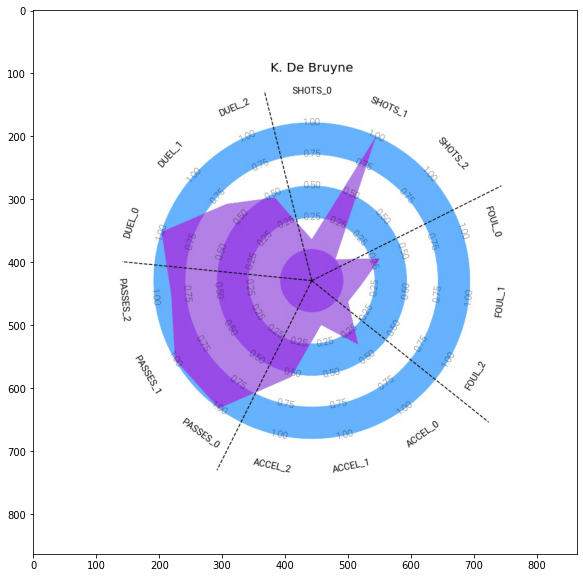

In [16]:
# example of the generated plots

plt.figure(figsize=(15, 10))
plt.imshow(Image.open('radar_plots/K. de Bruyne.jpg'))
plt.show()

## Comparing playing styles 

The playing vectors will be reduced to two dimensions, in order to allow visual comparison between different playing styles

In [614]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
new_feat = pca.fit_transform(total_features)
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

[0.36632377 0.27085395]
0.6371777196280742


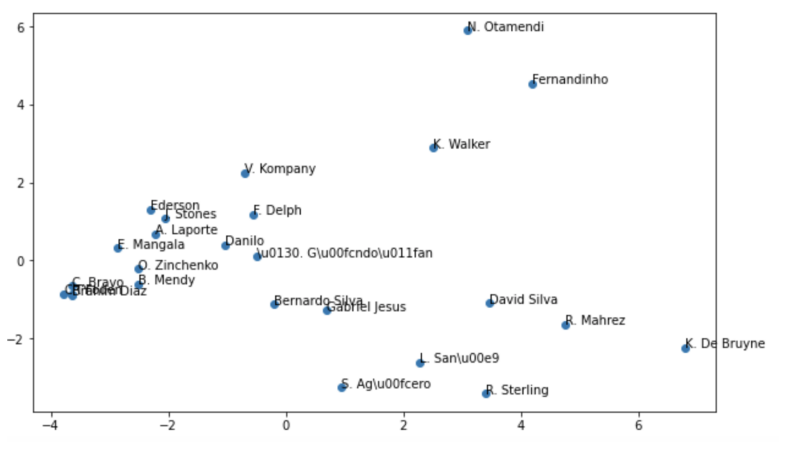

In [25]:
plt.figure(figsize=(10, 6))
plt.scatter(new_feat[:, 0], new_feat[:, 1])

for i in range(len(names)):
    plt.annotate(names[i], (new_feat[i, 0], new_feat[i, 1]))
    
plt.show()

Despite the dimension reduction was not perfect (reduction only explains 64% of the variance in the original playing vectors), it gives us some interesting clues. These can be seen visually in the *playing_styles* folder